In [3]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def select_score_features(score):
    return score.drop(columns=['category', 'age']).dropna(how='any')

def select_genetics_features(genetics):
    return genetics.drop(columns=['name', 'level_0'])

def select_milk_features(milk):
    return milk[['animal_id','date','milk_weight','days_since_calving']]

def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        score = pd.read_sql_table('classification', con)
        genetics = pd.read_sql_table('genetics', con)
        milk = pd.read_sql_table('milk_volume', con)
    return select_score_features(score), select_genetics_features(genetics), select_milk_features(milk)

In [4]:
score, genetics, milk = retrieve_data()

In [28]:
def monthly_sums_for_date_range(milk, start, end):
    """Return monthly sum of animal milk weight production"""
    date_mask = (milk['date'] >= start) & (milk['date'] <= end)
    milk = milk[date_mask]
    return milk.set_index('date').groupby('animal_id').resample('M').sum().fillna(0)['milk_weight'].reset_index()

def get_top_producers(milk, animal_count=25):
    """Return top n milk producers in dataframe"""
    milk = milk.groupby('animal_id').sum()['milk_weight'].sort_values(ascending=False)
    return milk.head(animal_count).reset_index()

def get_top_producers_for_date_range(milk, start, end, animal_count=25):
    monthly_milk = monthly_sums_for_date_range(milk, start, end)
    return get_top_producers(monthly_milk, animal_count)

def plot_top_producers(milk, start, end, animal_count=25):
    data = get_top_producers_for_date_range(milk, start, end, animal_count)
    
    top_25 = int(data['milk_weight'].quantile(0.75))
    top_50 = int(data['milk_weight'].quantile(0.50).values[0])
    top_75 = int(data['milk_weight'].quantile(0.25).values[0])
    
    ax = sns.barplot(y='milk_weight', x='animal_id', data=data, palette=sns.color_palette(n_colors=2))
    
    _ = plt.xticks(rotation='vertical')
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Weight Produced (Lb)')
    _ = plt.title(f'Top {animal_count} Animals by Milk Weight {start} to {end}')
    
    top25 = ax.axhline(top_25, ls='--', c='white', label='Top 25%')
    top50 = ax.axhline(top_50, ls='--', c='green', label='Top 50%')
    top75 = ax.axhline(top_75, ls='--', c='blue', label='Top 75%')
    plt.legend([top25, top50, top75], 
           [f'Top 25% ({top_25} lb)', f'Top 50% ({top_50} lb)', f'Top 75% ({top_75} lb)'], 
           loc='top left')
    return ax

## Top Producers for 2016

In [29]:
milk_2016 = monthly_sums_for_date_range(milk, '2016-01-01', '2016-11-01').groupby('animal_id').sum()

In [30]:


ax = plot_top_producers(milk, '2016-01-01', '2016-11-01')

plt.savefig('../reports/figures/top_producer_2016.png', dpi=300, bbox_inches='tight')
plt.show()

AttributeError: 'float' object has no attribute 'values'

In [24]:
top_producers_2016 = milk_2016.sort_values('milk_weight', ascending=False).head(25).index.values
top_producers_2016

array([1906, 1999, 1892, 1884, 1815, 1856, 1994, 1729, 2091, 1911, 1960,
       1773, 1991, 1531, 1908, 1898, 1711, 1998, 1993, 1918, 2045, 2075,
       1558, 1900, 2082])

## Top Producers for 2017

In [16]:
milk_2017 = monthly_sums_for_date_range(milk, '2017-01-01', '2017-11-01').groupby('animal_id').sum()

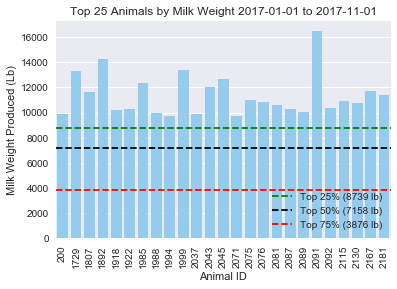

In [8]:
top_25 = int(milk_2017.quantile(0.75).values[0])
top_50 = int(milk_2017.quantile(0.50).values[0])
top_75 = int(milk_2017.quantile(0.25).values[0])

ax = plot_top_producers(milk, '2017-01-01', '2017-11-01')
top25 = ax.axhline(top_25, ls='--', c='green', label='Top 25%')
top50 = ax.axhline(top_50, ls='--', c='black', label='Top 50%')
top75 = ax.axhline(top_75, ls='--', c='red', label='Top 75%')
plt.legend([top25, top50, top75], 
           [f'Top 25% ({top_25} lb)', f'Top 50% ({top_50} lb)', f'Top 75% ({top_75} lb)'], 
           loc='lower right')
plt.savefig('../reports/figures/top_producer_2017.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
top_producers_2017 = milk_2017.sort_values('milk_weight', ascending=False).head(25).index.values
top_producers_2017

array([2091, 1892, 1999, 1729, 2045, 1985, 2043, 2167, 1807, 2181, 2075,
       2115, 2076, 2130, 2081, 2092, 1922, 2087, 1918, 2089, 1988, 2037,
        200, 1994, 2071])

In [10]:

def build_top_performer_profiles_dataframe(genetics, score, top_perfomers):
    data = pd.merge(left=score, right=genetics, left_on='animal_id', right_on='animal_id').drop(columns=['index_x', 'index_y'])
    return data[data['animal_id'].isin(repeat_performers)]

def generate_animal_profiles(data):
    report_table = data[['animal_id', 
                         'body_condition', 
                         'front_end_capacity_aggregate', 
                         'dairy_strength_aggregate', 
                         'rump_aggregate', 
                         'feet_and_legs_aggregate', 
                         'udder_score_aggregate', 
                         'final_score', 
                         'breed_age_average',
                         'date', 
                         'milk', 
                         'ctpi']]

In [ ]:
top_profiles = build_top_performer_profiles_dataframe(genetics, score, repeat_performers)
top_profiles = top_profiles.sort_values('date').drop_duplicates(keep='last')
top_profiles = top_profiles.set_index('animal_id')
top_profiles = top_profiles[['final_score', 'breed_age_average', 'ctpi', 'date']]
top_profiles = top_profiles.rename(index=str, columns={"final_score": "Final Score",
                                                       "breed_age_average": "Breed Age Average",
                                                       "ctpi": "Type Performance Index",
                                                       "date": "Last Classification Date"})
top_profiles = top_profiles.reset_index()

In [64]:
milk_2016 = monthly_sums_for_date_range(milk, '2016-01-01', '2016-11-01').groupby('animal_id').sum()
milk_2017 = monthly_sums_for_date_range(milk, '2017-01-01', '2017-11-01').groupby('animal_id').sum()
top_producers_2016 = milk_2016.sort_values('milk_weight', ascending=False).head(25).index.values
top_producers_2017 = milk_2017.sort_values('milk_weight', ascending=False).head(25).index.values

In [79]:
import numpy as np
repeat_performers = np.intersect1d(top_producers_2016, top_producers_2017)

milk_2016 = milk_2016.reset_index()
milk_2017 = milk_2017.reset_index()

repeat_2016 = milk_2016[milk_2016['animal_id'].isin(repeat_performers)].set_index('animal_id')['milk_weight'].reset_index()
repeat_2016['Year'] = 2016
repeat_2017 = milk_2017[milk_2017['animal_id'].isin(repeat_performers)].set_index('animal_id')['milk_weight'].reset_index()
repeat_2017['Year'] = 2017
repeat_performers = repeat_2016.append(repeat_2017)

In [97]:
def plot_repeat_performers_comparison(data):

    ax = sns.factorplot(x="animal_id", y="milk_weight", hue="Year", data=data,
                       kind="bar", palette="muted", size=5, aspect=3)
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Pounds')
    _ = plt.title('Total Annual Milk Weight for Repeat Top Performers 2016, 2017')
    ax = plt.gca()
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d lb' % int(p.get_height()), 
                fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig('../reports/figures/repeat_performers.png', dpi=300, bbox_inches='tight')
    plt.show()

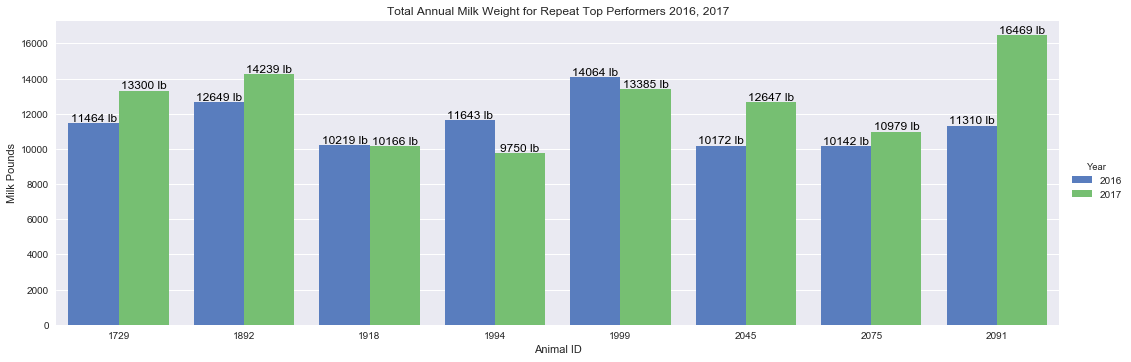

In [98]:
plot_repeat_performers_comparison(repeat_performers)

In [ ]:
def plot_milk_comparison(animal_ids, m1, m2, m1_year=2016, m2_year=2017):
    m1 = m1[m1['animal_id'].isin(animal_ids)].set_index('animal_id')['milk_weight'].reset_index()
    m1['Year'] = m1_year
    m2 = m2[m2['animal_id'].isin(animal_ids)].set_index('animal_id')['milk_weight'].reset_index()
    m2['Year'] = m2_year
    m = m1.append(m2)
    
    # Draw a nested barplot 
    ax = sns.factorplot(x="animal_id", y="milk_weight", hue="Year", data=m, kind="bar", palette="muted")
    ax.despine(left=True)
    plt.show()